# TRƯỜNG ĐẠI HỌC SƯ PHẠM KỸ THUẬT TP. HCM
## KHOA CÔNG NGHỆ THÔNG TIN
### BỘ MÔN KỸ THUẬT DỮ LIỆU

# Đề tài:
# ỨNG DỤNG PHƯƠNG PHÁP THỐNG KÊ VÀ HỌC MÁY DỰ ĐOÁN GIÁ NÔNG SẢN

<p>Họ và tên Sinh viên 1 : Huỳnh Hạo Nhị MSSV 1: 20133006 <p>
<br/>
Họ và tên Sinh viên 2 : Võ Hoài Thương MSSV 2: 20133012

### ARIMA Model cho dự đoán giá lúa

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

## Dữ liệu

Dữ liệu giá lúa được chúng tôi sử dụng của tỉnh An Giang, thu thập từ website của Trung
Tâm thông tin Phát triển Nông nghiệp Nông thôn từ 8/3/2007 đến nay.
Tổng quan về dữ liệu, giá lúa có nhiều biến động nhưng giữ được mức khá ổn định từ
năm 2012 đến cuối 2023. Từ đầu năm 2024 đến nay, dữ liệu giá lúa có xu hướng tặng
mạnh so với trước đây.

In [2]:
DATA_URL = "https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Lua/gia_lua.csv"

In [3]:
df_rice = pd.read_csv(DATA_URL)

In [4]:
df_rice.head()

,date,price
0,3/8/2007,4800
1,3/9/2007,4900
2,3/10/2007,4900
3,3/11/2007,4900
4,3/12/2007,4900


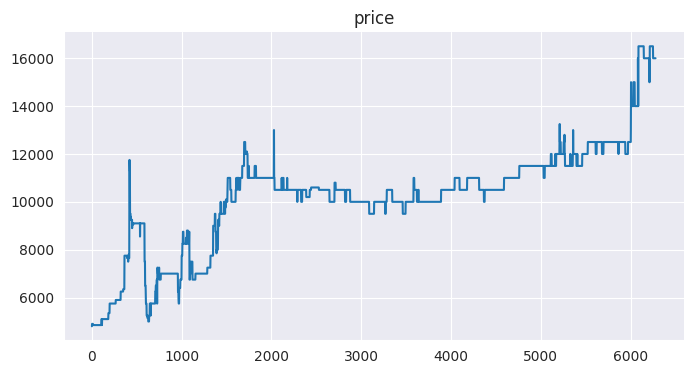

In [5]:
# @title EDA Data

from matplotlib import pyplot as plt
df_rice['price'].plot(kind='line', figsize=(8, 4), title='price')
plt.gca().spines[['top', 'right']].set_visible(False)

In [6]:
df_rice.set_index('date', inplace=True)

In [7]:
df_rice.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6279 entries, 3/8/2007 to 5/15/2024
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   price   6279 non-null   int64
dtypes: int64(1)
memory usage: 98.1+ KB


### Xử lí outlier

<Axes: >

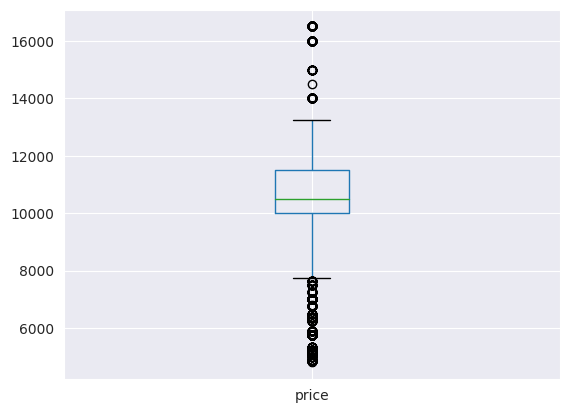

In [8]:
df_rice.boxplot()

In [9]:
# Tính toán ngưỡng cho outlier sử dụng IQR
Q1 = df_rice['price'].quantile(0.25)
Q3 = df_rice['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Xác định các dòng dữ liệu có giá trị nằm ngoài ngưỡng
outliers = df_rice[(df_rice['price'] < lower_bound) | (df_rice['price'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

# Kiểm tra và thay đổi giá trị nếu nó nằm ngoài ngưỡng
df_rice.at[df_rice.index[0], 'price'] = min(max(df_rice.iloc[0]['price'], lower_bound), upper_bound)

# Thay thế giá trị của outlier bằng giá trị trước đó
for index, row in outliers.iterrows():
    previous_date_index = df_rice.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df_rice.index[previous_date_index]
        previous_value = df_rice.loc[previous_date, 'price']
        df_rice.at[index, 'price'] = previous_value

Số lượng outlier: 1309


<Axes: >

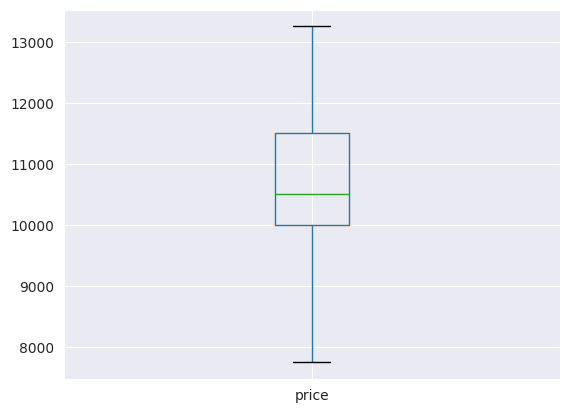

In [10]:
df_rice.boxplot()

<Axes: xlabel='date'>

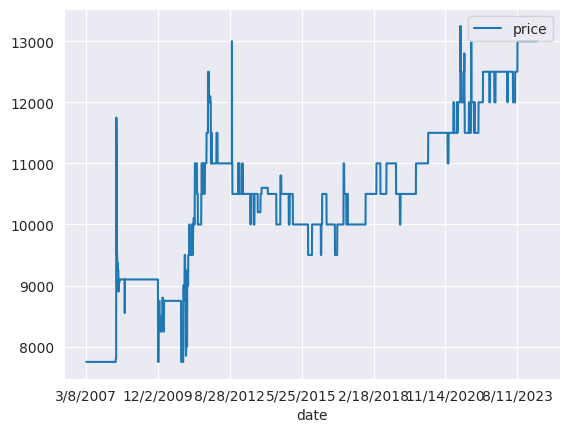

In [11]:
df_rice.plot()

### Smothing Data

In [12]:
df_rice = df_rice.rolling(45).mean()
df_rice = df_rice.dropna()

<Axes: xlabel='date'>

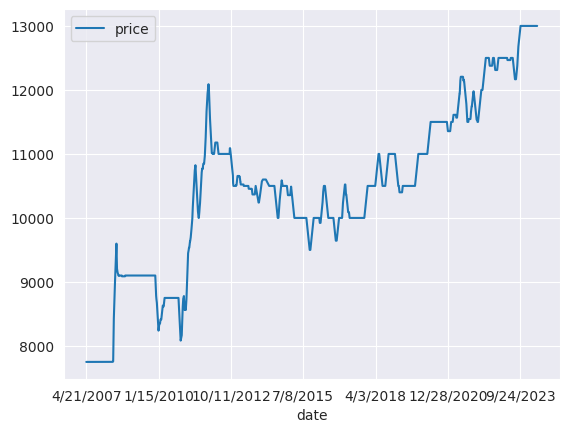

In [13]:
df_rice.plot()

- Trước khi xây dựng mô hình thống kê, chúng tôi cần thực hiện bước chuẩn bị dữ liệu từ
dữ liệu đã được tiền xử lý. Chúng tôi sẽ tính độ trễ, kiểm tra tính dừng (stationarity) và
lấy sai phân (differencing) để thể hiện được xu hướng và tính mùa vụ hoặc chu kỳ. Tiếp
đến, chúng tôi sử dụng các đồ thị tự tương quan để xác định các bậc p, q của mô hình.
- Trong bước xây dựng mô hình, chúng tôi sẽ kết hợp việc lặp qua các bộ tham số và sử
dụng đồ thị tự tương quan để tìm ra bộ tham số tối ưu với mục tiêu là giá trị Akaike’s
Information Criterion (AIC) nhỏ nhất.
- Dựa trên mô hình với bộ tham số vừa tìm để dự đoán và tính toán hiệu suất của mô hình.

# Kiểm tra tính dừng

In [14]:
def test_stationarity(timeseries):

    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=1).mean()
    movingSTD = timeseries.rolling(window=1).std()

    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)

    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

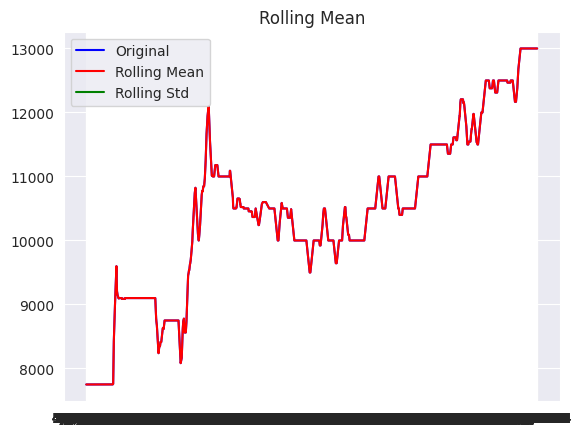

Results of Dickey Fuller Test:
Test Statistic                   -1.334261
p-value                           0.613356
#Lags Used                       34.000000
Number of Observations Used    6200.000000
Critical Value (1%)              -3.431405
Critical Value (5%)              -2.862006
Critical Value (10%)             -2.567018
dtype: float64


In [15]:
test_stationarity(df_rice.price)

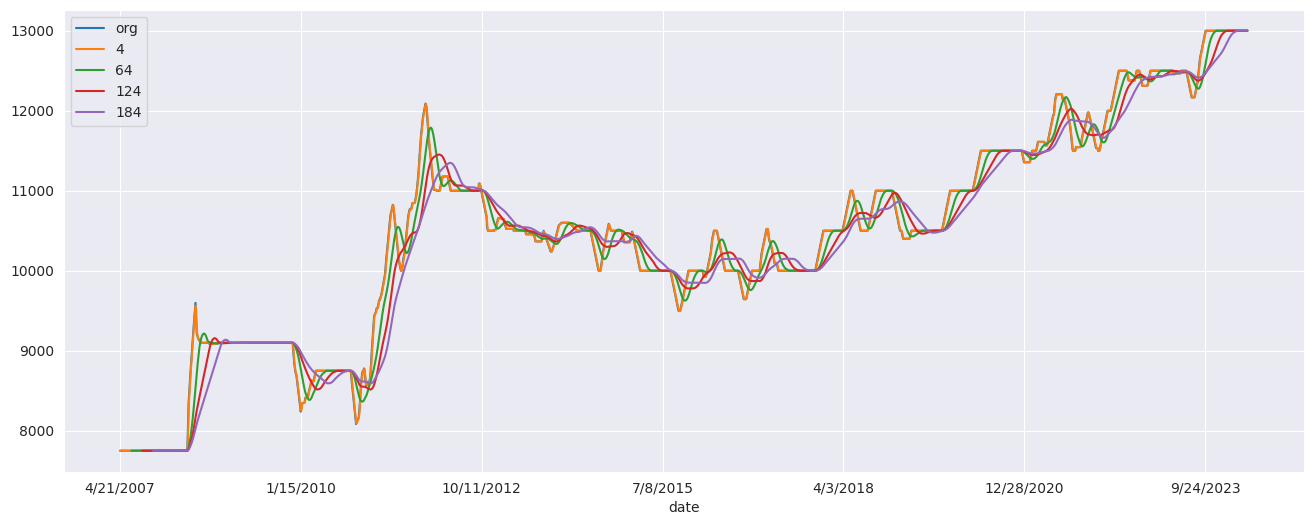

In [16]:
plt.figure(figsize=(16,6))
df_rice.price.plot(label="org")
for i in range(4,200,60):
    df_rice["price"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

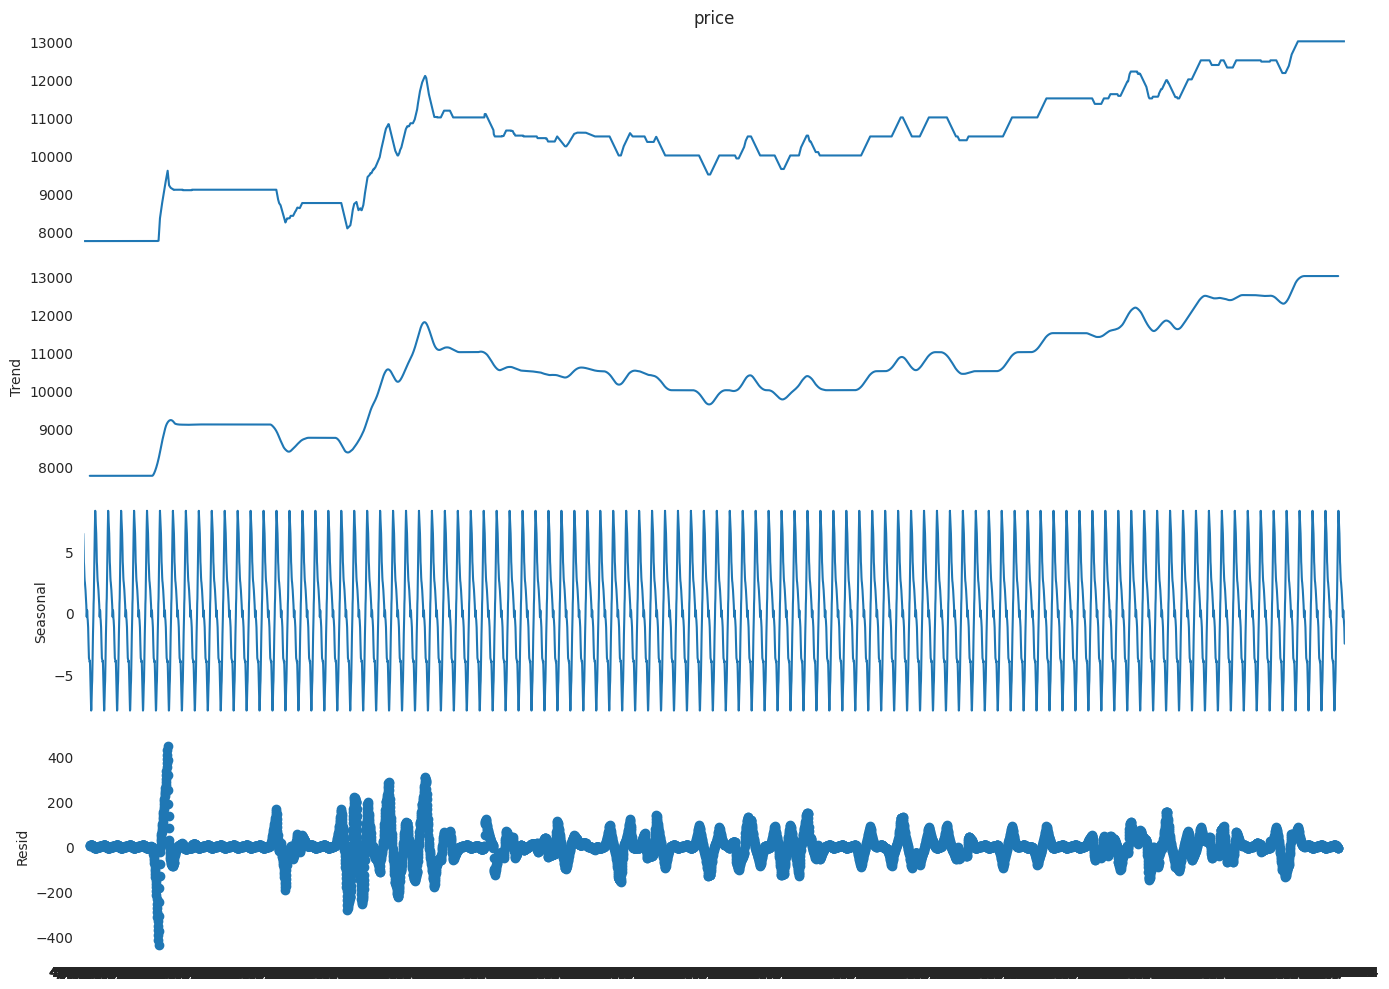

In [17]:
decompose_ts_add = seasonal_decompose(df_rice.price,period=64)
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

In [18]:
from statsmodels.tsa.stattools import pacf
pacf(df_rice.price, nlags=10)

array([ 1.        ,  0.9994867 , -0.04683151, -0.04201826, -0.03801221,
       -0.03430852, -0.03103196, -0.02798027, -0.02509521, -0.02317932,
       -0.02141516])

In [19]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,6))
    tsa_plots.acf(df_rice.price, nlags=10)
    plt.show()

In [20]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result = adfuller(series.dropna())
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [21]:
df1 = df_rice.price.copy()

### Kiểm tra tính dừng (stationarity), lấy sai phân (differencing) cho dữ liệu

Tiếp theo, chúng tôi kiểm tra tính dừng (stationarity), lấy sai phân (differencing) cho dữ
liệu bằng các phương pháp như Random Walk Model, Second-Order Differencing,
Seasonal Differencing, Augmented Dickey-Fuller. Phân rã chuỗi thời gian thành các
thành phần (decomposition) mang tính xu hướng, mùa vụ hoặc chu kỳ.

In [22]:
# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff

In [23]:
# invert differenced forecast
def inverse_difference(last_ob, value):
  return value + last_ob

In [24]:
diff = difference(df1, 60)

In [25]:
from matplotlib import pyplot

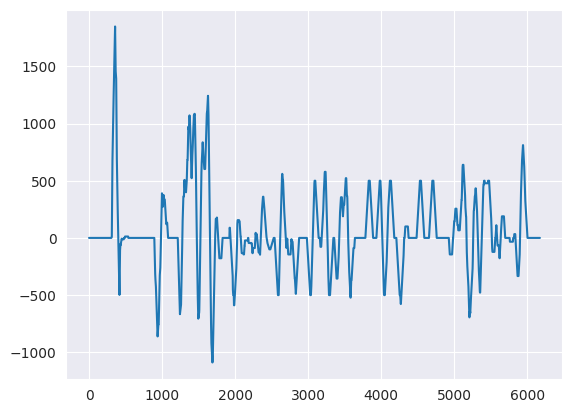

In [26]:
pyplot.plot(diff)
pyplot.show()

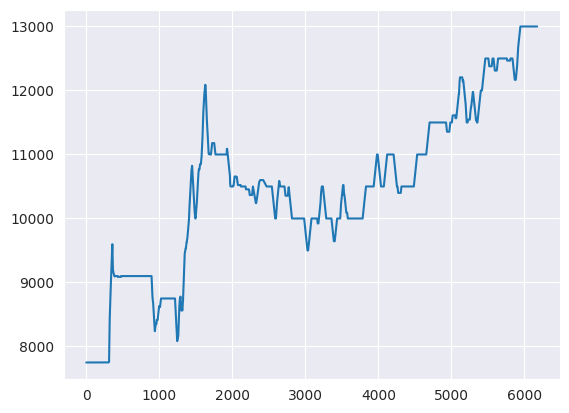

In [27]:
# invert the difference
inverted = [inverse_difference(df1[i], diff[i]) for i in range(len(diff))]
pyplot.plot(inverted)
pyplot.show()

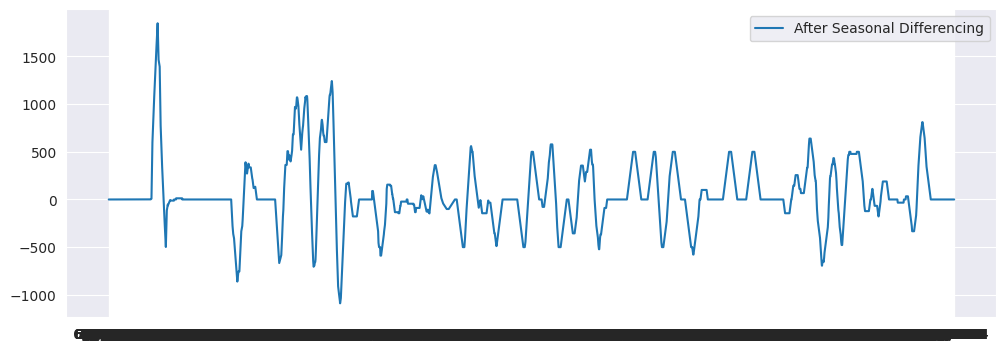

In [28]:
seasonal_differencing = df1 - df1.shift(60)
seasonal_differencing.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(seasonal_differencing, label='After Seasonal Differencing')
plt.legend(loc='best')
plt.show()

In [29]:
def revert_tranform_seasonal(df):
  return df + df.shift(60)

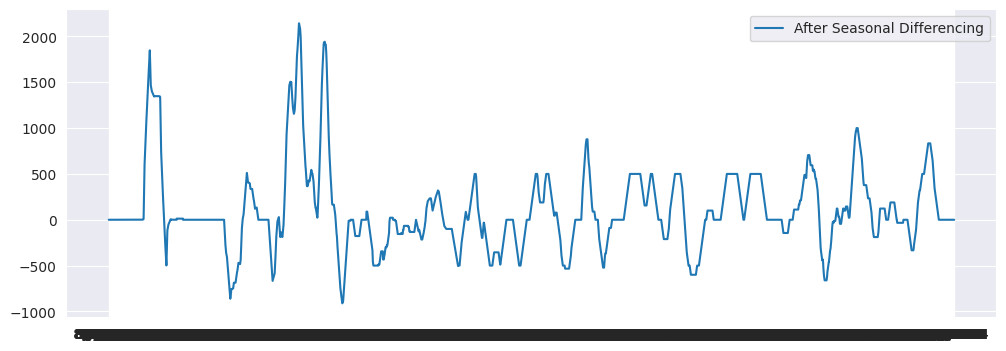

In [30]:
seasonal_revert = revert_tranform_seasonal(seasonal_differencing)
seasonal_revert.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(seasonal_revert, label='After Seasonal Differencing')
plt.legend(loc='best')
plt.show()

<Axes: xlabel='date'>

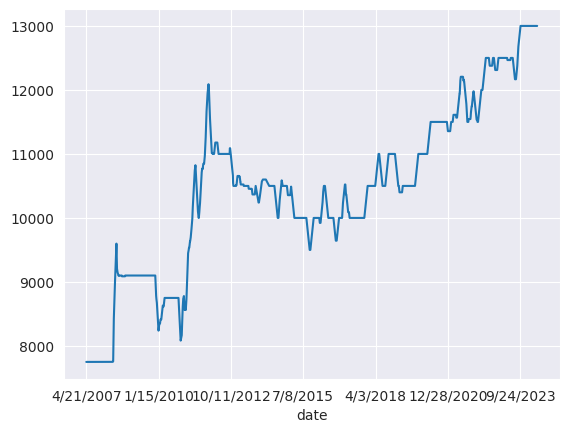

In [31]:
df1.plot()

### Log Scale Transformation

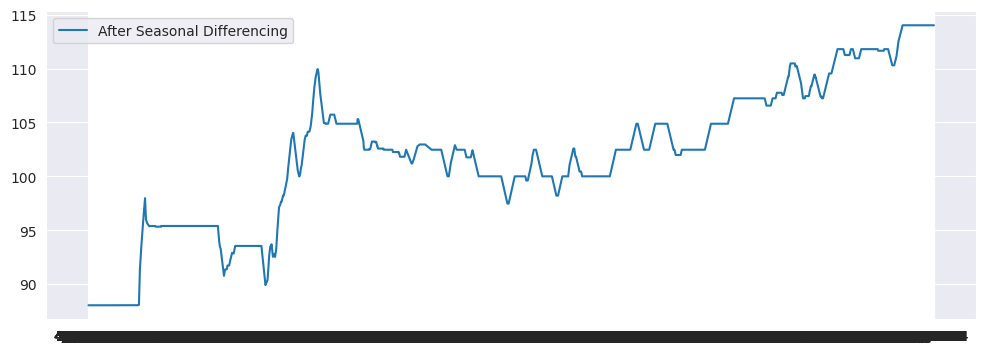

In [32]:
seasonal_box_plot = np.sqrt(df1)
seasonal_box_plot.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(seasonal_box_plot, label='After Seasonal Differencing')
plt.legend(loc='best')
plt.show()

In [33]:
def revert_tranform_seasonal(df):
  return np.square(df)

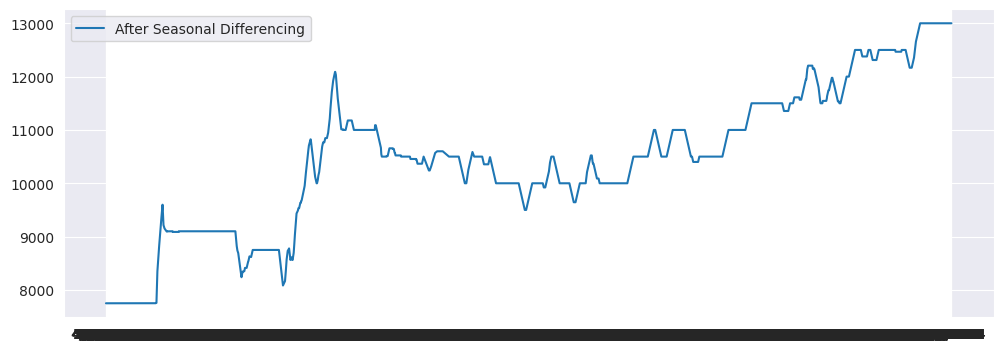

In [34]:
seasonal_revert = revert_tranform_seasonal(seasonal_box_plot)
seasonal_revert.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(seasonal_revert, label='After Seasonal Differencing')
plt.legend(loc='best')
plt.show()

In [35]:
adf_test(seasonal_box_plot)

Fail to reject the null hypothesis
Data is non-stationary


In [36]:
seasonal_differencing.info()

<class 'pandas.core.series.Series'>
Index: 6175 entries, 6/20/2007 to 5/15/2024
Series name: price
Non-Null Count  Dtype  
--------------  -----  
6175 non-null   float64
dtypes: float64(1)
memory usage: 96.5+ KB


In [37]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.9 MB/s eta 0:00:00


In [38]:
df_rice.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6235 entries, 4/21/2007 to 5/15/2024
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   6235 non-null   float64
dtypes: float64(1)
memory usage: 97.4+ KB


In [39]:
df1 = df1.copy()

In [40]:
# df1['price'] = df_rice["price"].rolling(60).mean()

In [42]:
df1 = df1.dropna()


In [43]:
df1.info()

<class 'pandas.core.series.Series'>
Index: 6235 entries, 4/21/2007 to 5/15/2024
Series name: price
Non-Null Count  Dtype  
--------------  -----  
6235 non-null   float64
dtypes: float64(1)
memory usage: 97.4+ KB


In [44]:
size = int(len(df1) * 0.8)
train_data = df1[:size]
test_data = df1[size:]

In [46]:
train_data =  train_data.diff()

In [47]:
train_data.info()
train_data = train_data.dropna()

<class 'pandas.core.series.Series'>
Index: 4988 entries, 4/21/2007 to 12/15/2020
Series name: price
Non-Null Count  Dtype  
--------------  -----  
4987 non-null   float64
dtypes: float64(1)
memory usage: 77.9+ KB


<Axes: xlabel='date'>

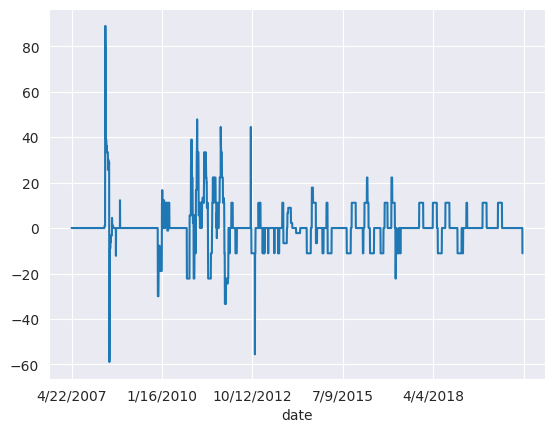

In [48]:
train_data.plot()

Sau khi tiến hành các phương pháp stationary dữ liệu đã stationary

In [49]:
adf_test(train_data)

Reject the null hypothesis
Data is stationary


In [50]:
diff_data = train_data.copy()
diff_data.iloc[0] = train_data.iloc[0]

# Compute the cumulative sum to revert the diff transformation
reverted_data = diff_data.cumsum()

<Axes: xlabel='date'>

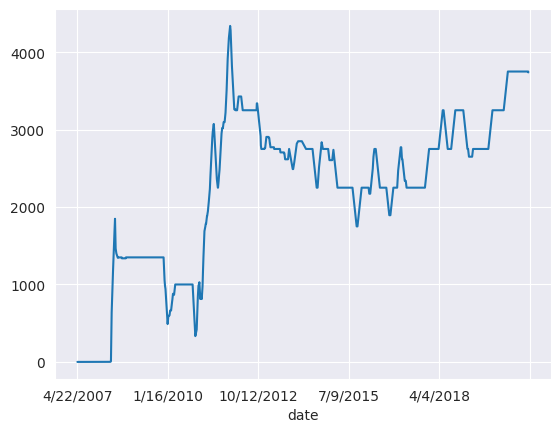

In [51]:
reverted_data.plot()

In [52]:
size

4988

In [53]:
train_data.values

array([  0.        ,   0.        ,   0.        , ...,   0.        ,
         0.        , -11.11111111])

## ARIMA MODEL

Mô hình ARIMA: Dựa trên giả thuyết chuỗi dừng và phương sai sai số không đổi. Mô hình sử dụng đầu vào chính là những tín hiệu quá khứ của chuỗi được dự báo để dự báo nó. Các tín hiệu đó bao gồm: chuỗi tự hồi qui AR (auto regression) và chuỗi trung bình trượt MA (moving average). Hầu hết các chuỗi thời gian sẽ có xu hướng tăng hoặc giảm theo thời gian, do đó yếu tố chuỗi dừng thường không đạt được. Trong trường hợp chuỗi không dừng thì ta sẽ cần biến đổi sang chuỗi dừng bằng sai phân. Khi đó tham số đặc trưng của mô hình sẽ có thêm thành phần bậc của sai phân d và mô hình được đặc tả bởi 3 tham số ARIMA(p, d, q).


Tiến hành huấn luyện và chọn mô hình có đánh giá Akaike’s Information Criterion
(AIC) nhỏ nhất.

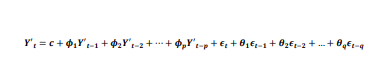

In [54]:
import pmdarima as pm

model_arima = pm.auto_arima(train_data.values, start_p=3, start_q=3,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=25821.874, Time=9.46 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=36771.795, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=25872.563, Time=0.30 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=31997.907, Time=1.18 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=25861.741, Time=3.12 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=25830.974, Time=8.79 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=25802.742, Time=12.05 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=25802.750, Time=8.57 sec
 ARIMA(5,0,3)(0,0,0)[0]             : AIC=25826.359, Time=5.64 sec
 ARIMA(4,0,4)(0,0,0)[0]             : AIC=25803.712, Time=7.91 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=25809.901, Time=5.83 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=25856.696, Time=6.87 sec
 ARIMA(5,0,4)(0,0,0)[0]             : AIC=inf, Time=8.11 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=25803.993, Time=9.57 sec

Best model:  ARIMA(4,0,

Kiểm tra kết quả

In [55]:
n_periods = len(test_data)
fc, confint = model_arima.predict(n_periods=n_periods, return_conf_int=True, dynamic=True)
index_of_fc = np.arange(len(test_data), len(test_data.values) + n_periods)

In [58]:
fc_series = pd.Series(np.square(fc), index=test_data.index)

In [59]:
test_data.info()

<class 'pandas.core.series.Series'>
Index: 1247 entries, 12/16/2020 to 5/15/2024
Series name: price
Non-Null Count  Dtype  
--------------  -----  
1247 non-null   float64
dtypes: float64(1)
memory usage: 19.5+ KB


<Axes: xlabel='date'>

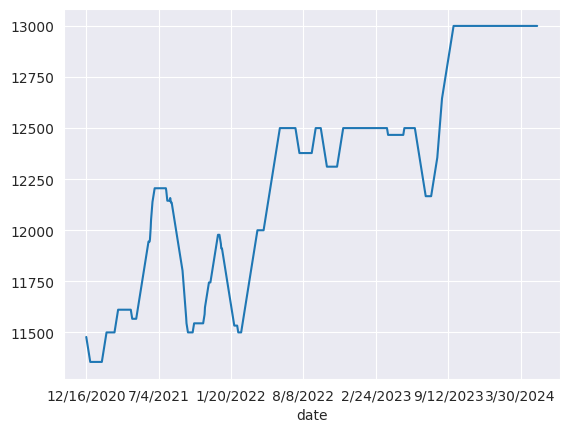

In [60]:
test_data.plot()

<Axes: xlabel='date'>

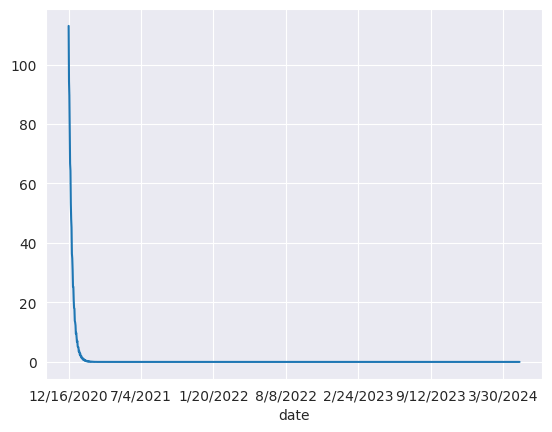

In [61]:
fc_series.plot()

Để đưa dữ liệu dự báo về cùng thang đo với dữ liệu thực tế, cần thực hiện bước chuẩn
hóa: giá trị dự báo cuối cùng (forecast) được tính bằng tổng giá trị thực tế cuối cùng
(actual.iloc[-1]) cộng với tổng giá trị dự báo tích lũy (predict.cumsum)

In [63]:
diff_data = fc_series.copy()

reverted_data = test_data.iloc[0] + diff_data.cumsum()
# Compute the cumulative sum to revert the diff transformation


<Axes: xlabel='date'>

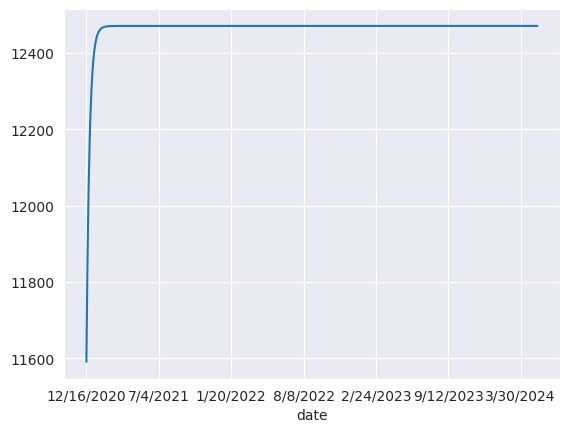

In [64]:
reverted_data.plot()

In [65]:
test_data

date
12/16/2020    11477.777778
12/17/2020    11466.666667
12/18/2020    11455.555556
12/19/2020    11444.444444
12/20/2020    11433.333333
                  ...     
5/11/2024     13000.000000
5/12/2024     13000.000000
5/13/2024     13000.000000
5/14/2024     13000.000000
5/15/2024     13000.000000
Name: price, Length: 1247, dtype: float64

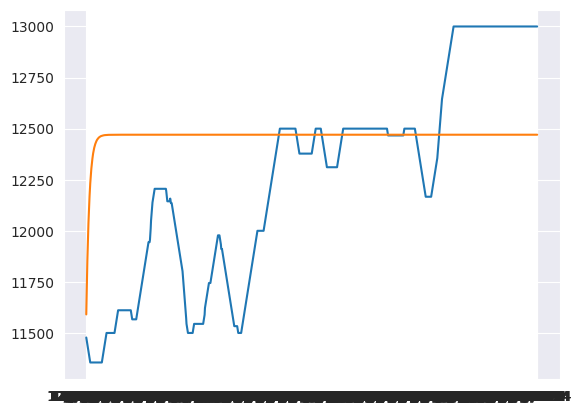

In [67]:
#plot the predictions for validation set
# plt.plot(train_data_inverse, label='Train')
plt.plot(test_data, label='Valid')
plt.plot(reverted_data, label='Prediction')
plt.show()

- Để kiểm tra hiệu suất mô hình đã xây dựng, chúng tôi đánh giá hiệu suất trên tập huấn
luyện và kiểm tra với việc tính sai số rmse và mape.
- Sau khi hoàn thành huấn luyện và đánh giá hiệu suất mô hình, chúng tôi tinh chỉnh các
tham số, huấn luyện lại mô hình nhiều lần để tìm ra mô hình với bộ tham số thật tối ưu.

In [69]:
from sklearn.metrics import mean_absolute_percentage_error

def forecast_accuracy(forecast, actual):
    mape = mean_absolute_percentage_error(actual, forecast) * 100  # MAPE     # ME
    rmse = np.mean((forecast - actual)**2)**.5  # RMS
    return({'mape':mape, 'rmse':rmse})

In [70]:
forecast_accuracy(test_data.values, reverted_data.values)

{'mape': 3.4224123869920478, 'rmse': 541.9841452246686}

In [77]:
import joblib
from google.colab import drive

file_name = "arima_gia_lua.joblib"
drive.mount('/content/drive')

joblib.dump(model_arima,'/content/drive/MyDrive/model/' + file_name)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['/content/drive/MyDrive/model/arima_gia_lua.joblib']